In [1]:
!unzip "/content/acea-water-prediction.zip"

Archive:  /content/acea-water-prediction.zip
  inflating: Aquifer_Auser.csv       
  inflating: Aquifer_Doganella.csv   
  inflating: Aquifer_Luco.csv        
  inflating: Aquifer_Petrignano.csv  
  inflating: Lake_Bilancino.csv      
  inflating: River_Arno.csv          
  inflating: Water_Spring_Amiata.csv  
  inflating: Water_Spring_Lupa.csv   
  inflating: Water_Spring_Madonna_di_Canneto.csv  
  inflating: datasets_description.ods  
  inflating: datasets_description.xlsx  


# Intro
This is an exploration of time seriessssssss
ill be probably doing stuff with data that is prev imported
ill be looking at this following tutorial or something
- https://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide/notebook
- https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting
- https://www.kaggle.com/iamleonie/eda-quenching-the-thirst-for-insights


# Import some stuuf

In [2]:
!pip install colorama

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

np.random.seed(7)

# ++++++++++ The Guide by Andreshg ++++++++++

# Import the data

In [4]:
df = pd.read_csv("Aquifer_Petrignano.csv")
df

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5218,26/06/2020,0.0,-25.68,-25.07,25.7,24.5,-29930.688,2.5
5219,27/06/2020,0.0,-25.80,-25.11,26.2,25.0,-31332.960,2.4
5220,28/06/2020,0.0,-25.80,-25.19,26.9,25.7,-32120.928,2.4
5221,29/06/2020,0.0,-25.78,-25.18,26.9,26.0,-30602.880,2.4


So there is and old rows, jadi ada beberapa yang sekitar tahun 2006 sampai 2009 itu ada null

nah itu semua dihapus dan cara simple sepertin ini, merujuk satu feature

In [5]:
# Remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
df

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2009,0.0,-31.96,-31.14,5.2,4.9,-24530.688,2.4
1,02/01/2009,0.0,-32.03,-31.11,2.3,2.5,-28785.888,2.5
2,03/01/2009,0.0,-31.97,-31.07,4.4,3.9,-25766.208,2.4
3,04/01/2009,0.0,-31.91,-31.05,0.8,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.94,-31.01,-1.9,-2.1,-29854.656,2.3
...,...,...,...,...,...,...,...,...
4194,26/06/2020,0.0,-25.68,-25.07,25.7,24.5,-29930.688,2.5
4195,27/06/2020,0.0,-25.80,-25.11,26.2,25.0,-31332.960,2.4
4196,28/06/2020,0.0,-25.80,-25.19,26.9,25.7,-32120.928,2.4
4197,29/06/2020,0.0,-25.78,-25.18,26.9,26.0,-30602.880,2.4


In [6]:
df.isna().sum()

Date                                     0
Rainfall_Bastia_Umbra                    0
Depth_to_Groundwater_P24                39
Depth_to_Groundwater_P25                27
Temperature_Bastia_Umbra                 0
Temperature_Petrignano                   0
Volume_C10_Petrignano                    1
Hydrometry_Fiume_Chiascio_Petrignano     0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rainfall_Bastia_Umbra,4199.0,1.556633,5.217923,0.000,0.000,0.000,0.100,67.30
Depth_to_Groundwater_P24,4160.0,-25.713707,3.039621,-34.470,-27.460,-25.550,-23.640,-19.66
Depth_to_Groundwater_P25,4172.0,-25.182534,2.945074,-33.710,-26.860,-25.170,-23.270,-19.10
Temperature_Bastia_Umbra,4199.0,15.030293,7.794871,-3.700,8.800,14.700,21.400,33.00
Temperature_Petrignano,4199.0,13.739081,7.701369,-4.200,7.700,13.500,20.000,31.10
Volume_C10_Petrignano,4198.0,-28669.156619,4570.686434,-41890.176,-31082.832,-28389.744,-26042.904,0.00
Hydrometry_Fiume_Chiascio_Petrignano,4199.0,2.372517,0.589088,0.000,2.100,2.400,2.700,4.10


Remove not usefull columns

In [8]:
# Remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)
df

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3
...,...,...,...,...,...,...
4194,26/06/2020,0.0,-25.07,25.7,-29930.688,2.5
4195,27/06/2020,0.0,-25.11,26.2,-31332.960,2.4
4196,28/06/2020,0.0,-25.19,26.9,-32120.928,2.4
4197,29/06/2020,0.0,-25.18,26.9,-30602.880,2.4


Simplify column names

In [9]:
# Simplify column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets] 
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


Since this is a TimeSeries problem, we have to parse 'date' column

In [10]:
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


# Data visualization

Features:

- Rainfall indicates the quantity of rain falling (mm)


- Temperature indicates the temperature (°C)

- Volume indicates the volume of water taken from the drinking water treatment plant (m 3 )

- Hydrometry indicates the groundwater level (m)

Target:

- Depth to Groundwater indicates the groundwater level (m from the ground floor)

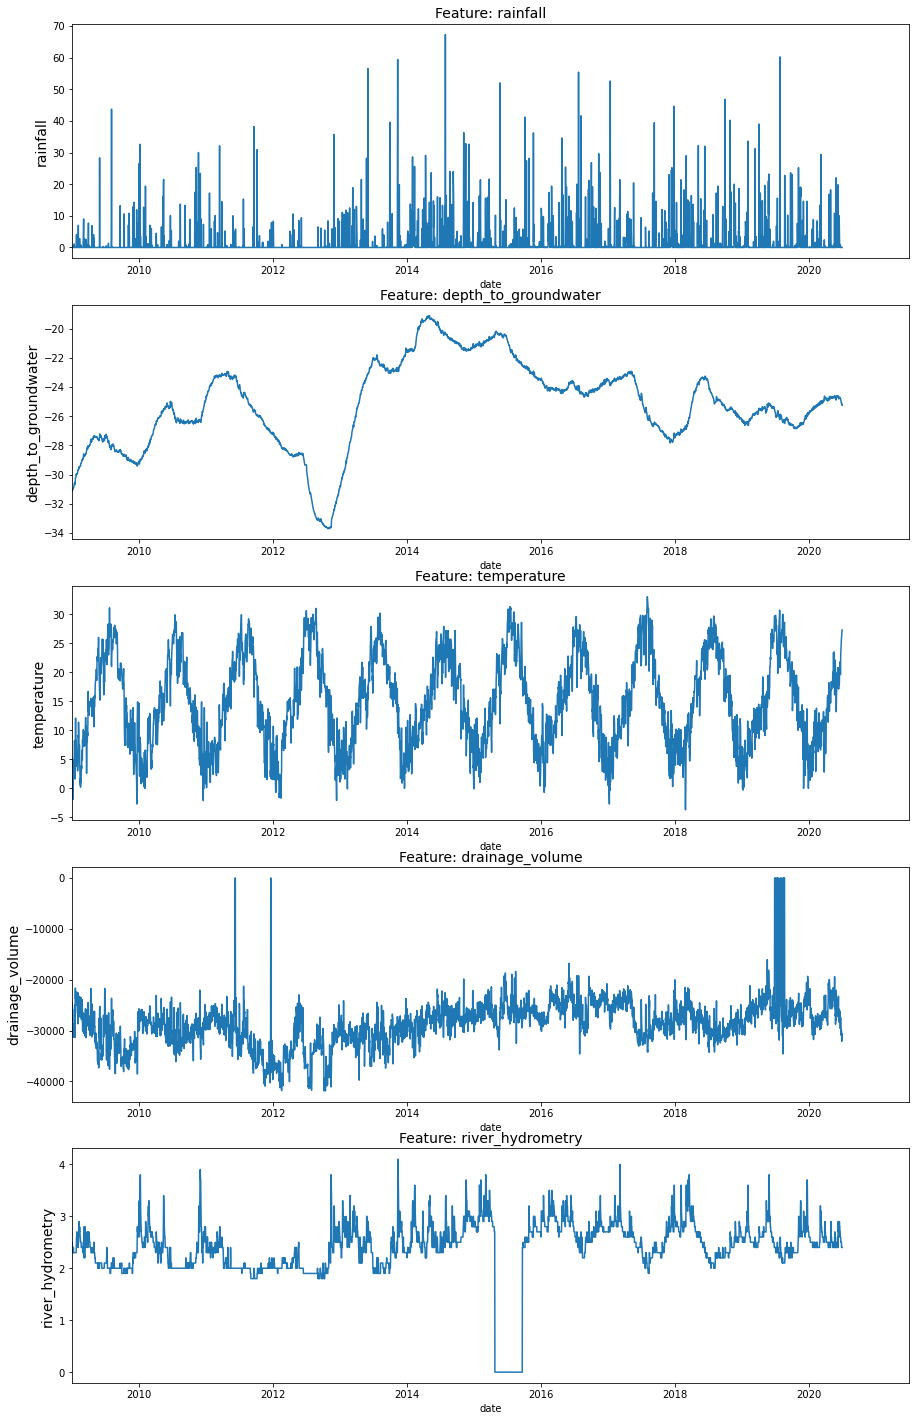

In [11]:
# To compelte the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), # <-- here is when we use forward fill the empty values
                  ax=ax[i], color='tab:blue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2021, 6, 30)]) 

# Data Preprocessing

## Chronological Order and Equidistant Timestamps

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [12]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


so, the data shape is 4199, so what we do to see if the data is sorted by date is to just sum all the delte value (delta being the one that we just created to see if certain row and the row after that is 1 day between them in the date columb)

if the date is fully shorted and the distance between every row is one day, the sum of all the delta value should be 4198 which is equal to the shape[0] - 1 of the data

-1 being the first ever row is NaT

In [13]:
df.shape[0]

4199

In [14]:
df['delta'].sum(), df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

## Handle Missings

As we can see, the dataset has some null values.

Furthermore, plotting the time series reveals that there seem to be some zero values that seems to be nulls for drainage_volume, and river_hydrometry. We will have to clean them by replacing them by nan values and filling them afterwards

In [15]:
df = df.drop('delta', axis=1)
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

so what this graph basicly do, show the difference between the graph with the having the 0 values as the orange colored

and the blue one is for the graph that does not have 0 values butttttt\
its replace with NaN\
so as you can see in the river_hydrometry graph, the blue line just goes straight to the nect value, as can see in a linear graph here:\
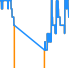

same thing for the other graph:

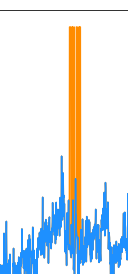

(733408.0, 737606.0)

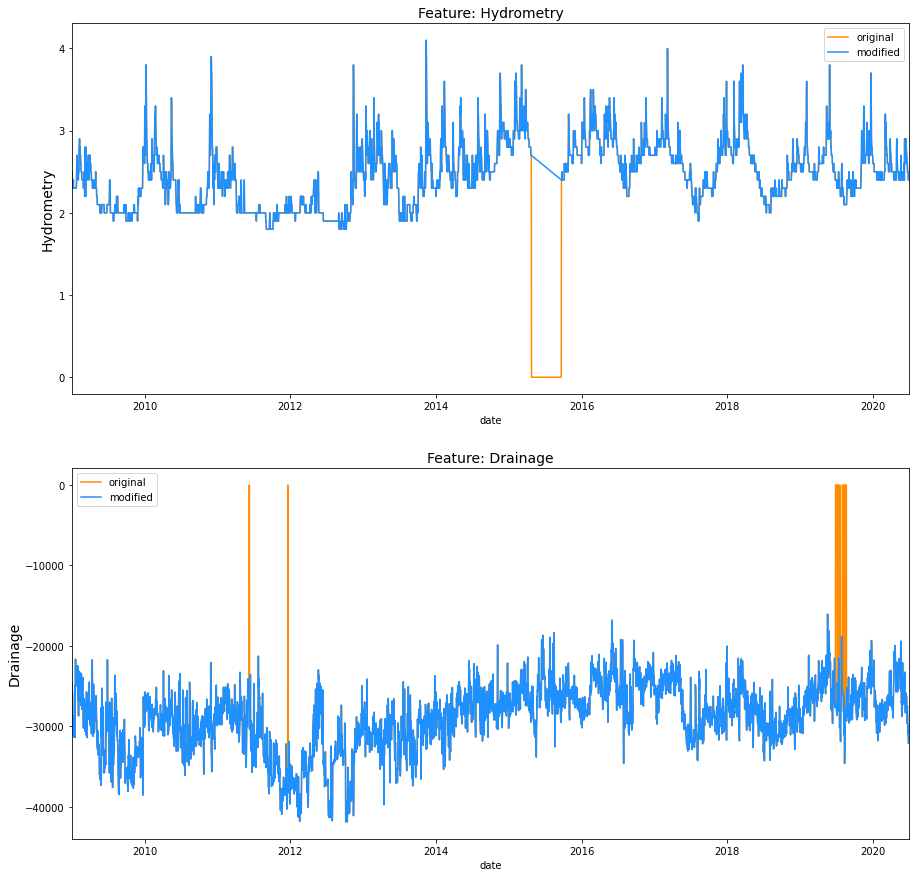

In [16]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

# so this plot the old graph with 0 values
sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original') 
# and the this one overlaps it, being the 0 is replace with NaN
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified') 
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Same thing applies to the next grahp
old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

So okay, NaN values\
So now we have to fix missing values. Lets take a look of these cases and explore what can we do with them.

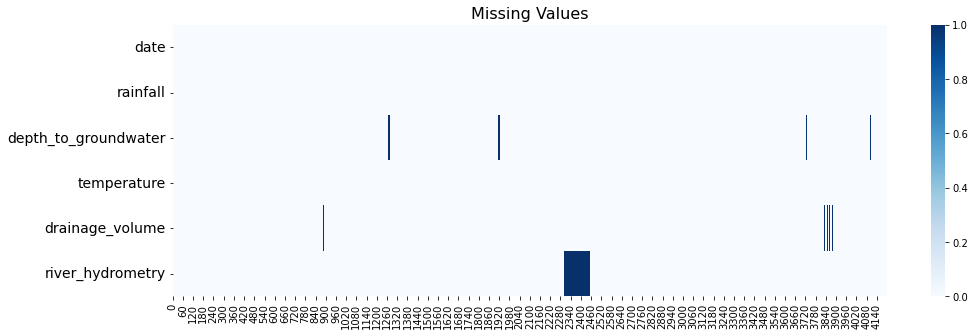

In [17]:
plt.figure(figsize=(16,5))
sns.heatmap(df.T.isna(), cmap='Blues')
plt.title('Missing Values', fontsize=16)
plt.yticks(fontsize=14)
plt.show()

Missing Values, how to handle
- Option 1: Fill NaN with Outlier or Zero\
In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

- ption 2: Fill NaN with Mean Value\
Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

- Option 3: Fill NaN with Last Value with .ffill()\
Filling NaNs with the last value could be bit better.

- Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()\
Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring value

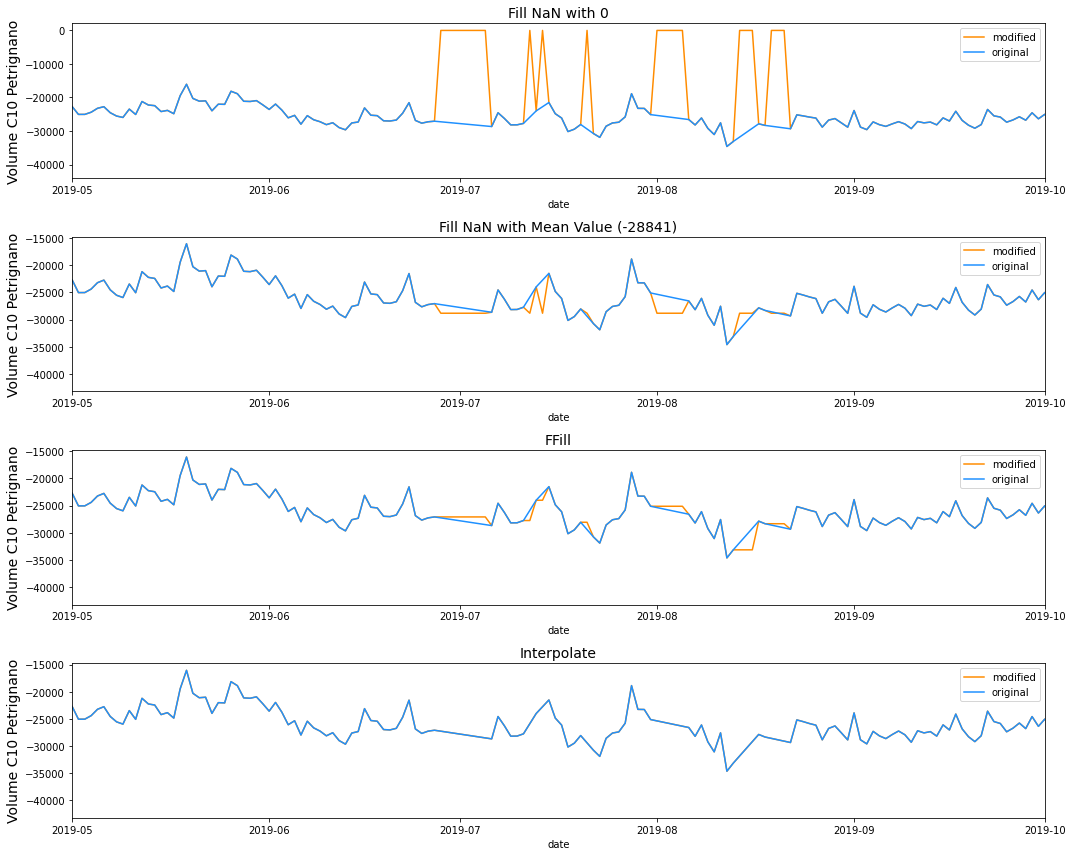

In [18]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
    
plt.tight_layout()
plt.show()

the last part should be like this
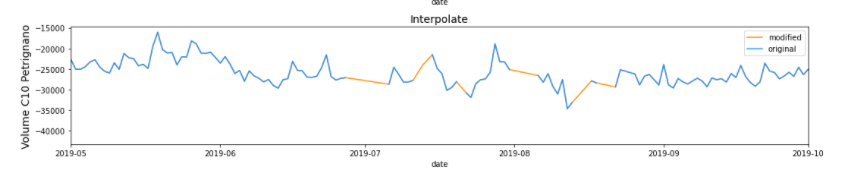

As we can see, the best option in this case, interplota seems to best option!

So, lets interplota missing values

In [19]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

## Smoothing data / Resampling

Resampling can provide additional information on the data. There are two types of resampling:

- Upsampling is when the frequency of samples is increased (e.g. days to hours)
- Downsampling is when the frequency of samples is decreased (e.g. days to weeks)

In this example, we will do some downsampling with the .resample() function (similar to groupby and aggregate as mean).

the resample function usualy takes two things/column, like a certain column like date and a numerical value related to that

the resample function can be use like the following,


In [20]:
df[['date','drainage_volume']].resample('7D', on='date')

In [21]:
df[['date','drainage_volume']].resample('7D', on='date').sum()

,drainage_volume
date,
2009-01-01,-197154.432
2009-01-08,-208290.528
2009-01-15,-178242.336
2009-01-22,-166980.960
2009-01-29,-176473.728
...,...
2020-05-28,-179137.440
2020-06-04,-171969.696
2020-06-11,-190248.912


In [22]:
df[['date','temperature']].resample('M', on='date').mean().reset_index(drop=True)

,temperature
0,4.964516
1,5.125000
2,9.254839
3,13.806667
4,19.809677
...,...
133,8.989655
134,9.758065
135,14.016667
136,18.754839


In [23]:
df[['date','temperature']].resample('M', on='date').mean().reset_index(drop=False)

,date,temperature
0,2009-01-31,4.964516
1,2009-02-28,5.125000
2,2009-03-31,9.254839
3,2009-04-30,13.806667
4,2009-05-31,19.809677
...,...,...
133,2020-02-29,8.989655
134,2020-03-31,9.758065
135,2020-04-30,14.016667
136,2020-05-31,18.754839


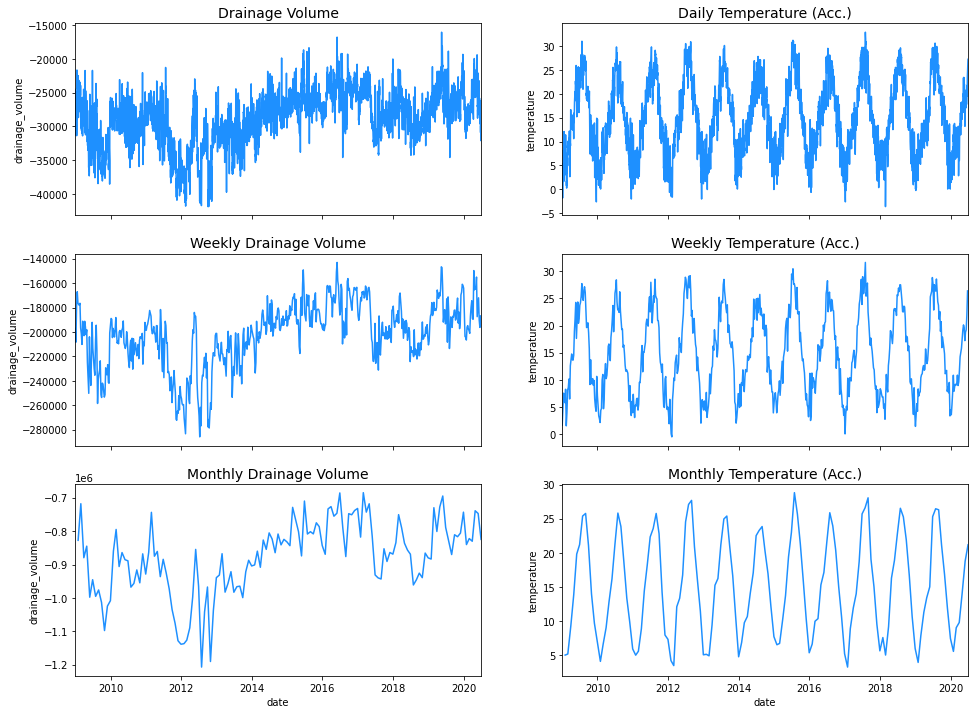

In [24]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(df['date'], df['drainage_volume'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(df['date'], df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

In [25]:
# As we can see, downsample to weekly could smooth the data and hgelp with analysis
downsample = df.resample('7D', on='date').mean().reset_index(drop=False).copy()
df = downsample.copy()

## Stationarity

Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

- constant mean and mean is not time-dependent
- constant variance and variance is not time-dependent
- constant covariance and covariance is not time-dependent

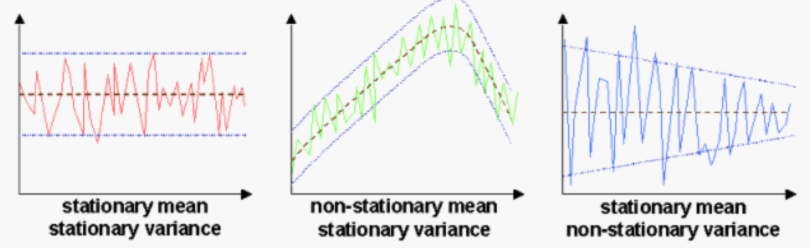

The check for stationarity can be done via three different approaches:

- visually: plot time series and check for trends or seasonality
- basic statistics: split time series and compare the mean and variance of each partition
- statistical test: Augmented Dickey Fuller test

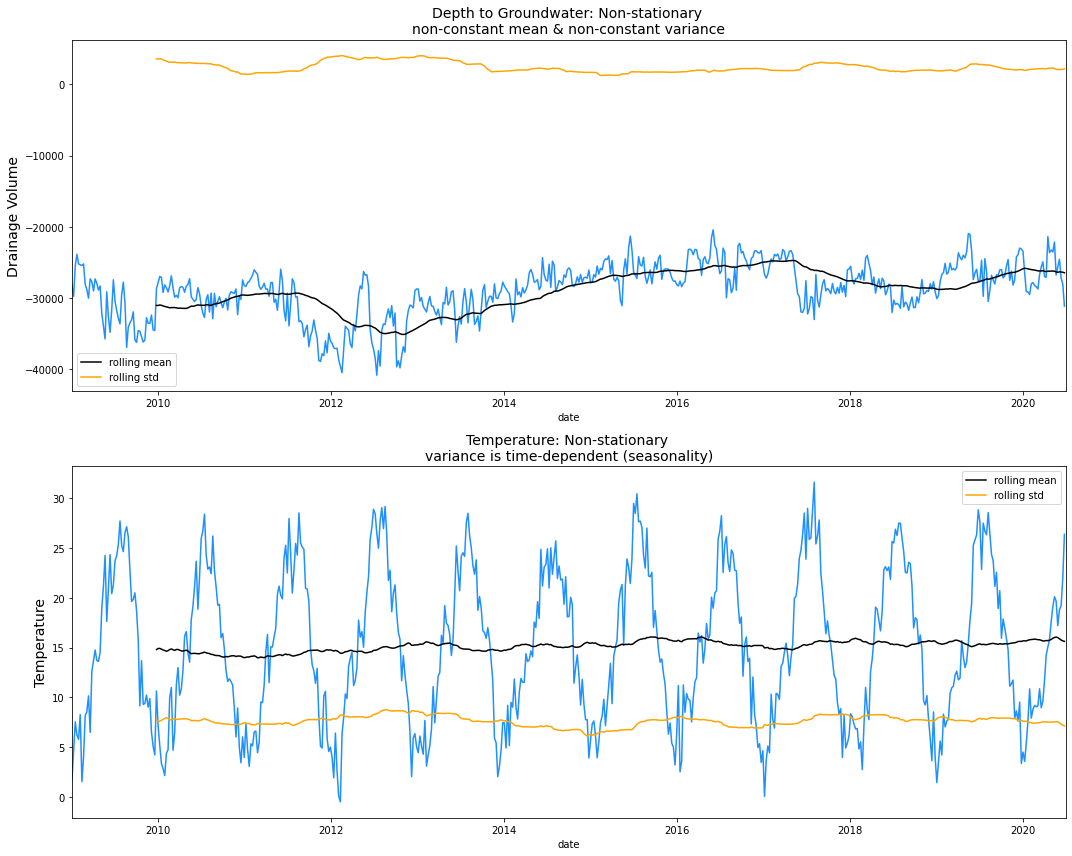

In [26]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In this visual check, we can see that the features don't have constant mean and std, but they are close to it.

So that is the visual way, now for the statistical test

## Unit Root Test

Unit root is a characteristic of a time series that makes it non-stationary. And ADF test belong to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in below equation.

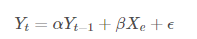
 
where Yt is value of the time series at time ‘t’ and Xe is an exogenous variable .

The presence of a unit root means the time series is non-stationary.

### Augmented Dickey-Fuller (ADF)

Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

- Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

- Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

**If the null hypothesis can be rejected, we can conclude that the time series is stationary.**

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

- **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

- **ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- **ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

and here is the code FOr ADF and finding that p value


In [27]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-2.880201649316664,
 0.047699190920208426,
 7,
 592,
 {'1%': -3.441444394224128,
  '10%': -2.569376663737217,
  '5%': -2.8664345376276454},
 -734.3154255877625)

and looking at the documentation, the p value is the second return value
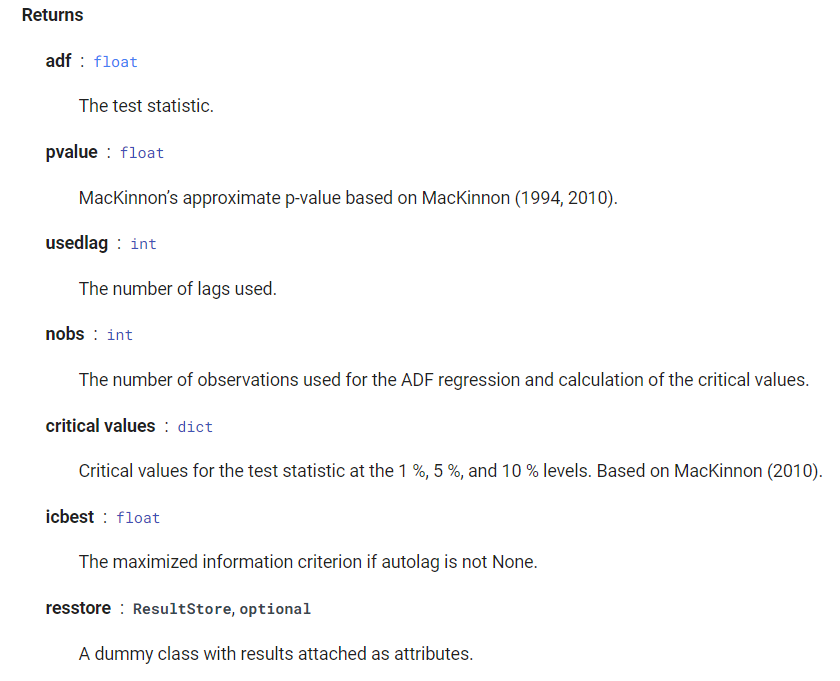

with the p value being 0.047 and its lower than 0.05 then we can reject H0 and we can say that the depth_to_groundwater is staionary

Now, we are going to check for each variable:

- The p-value is less than 0.05
- Check the range of the ADF statistic compared with critical_values

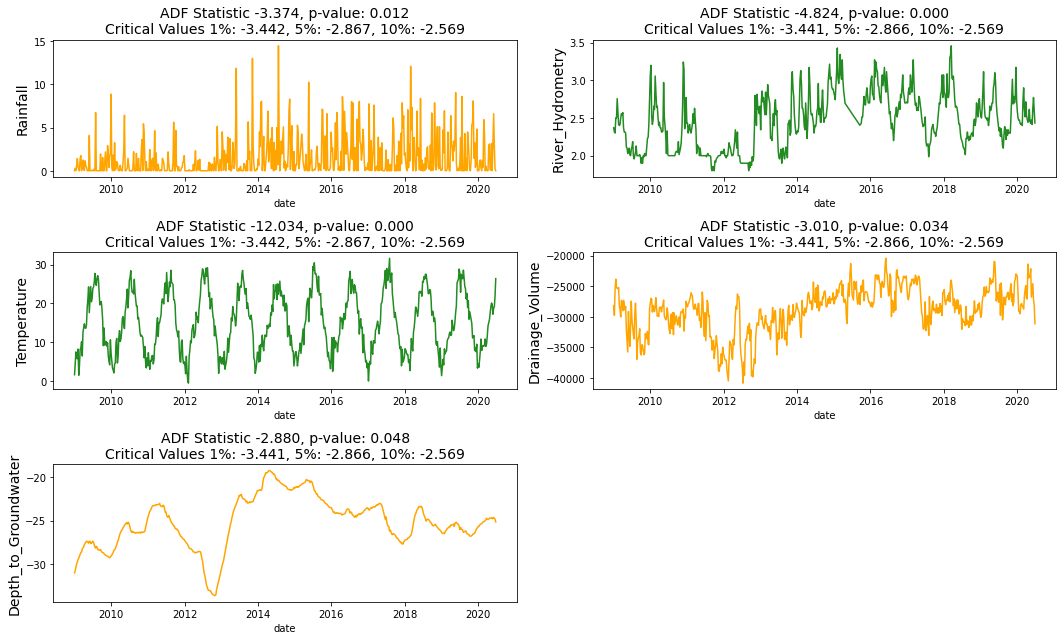

In [28]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1]) # <- used to remove the Axes ax from its figure.
plt.tight_layout() # <- used to automatically adjust subplot parameters to give specified padding
plt.show()

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

- **Transformation**: e.g. log or square root to stabilize non-constant variance
- **Differencing**: subtracts the current value from the previous

### Transforming

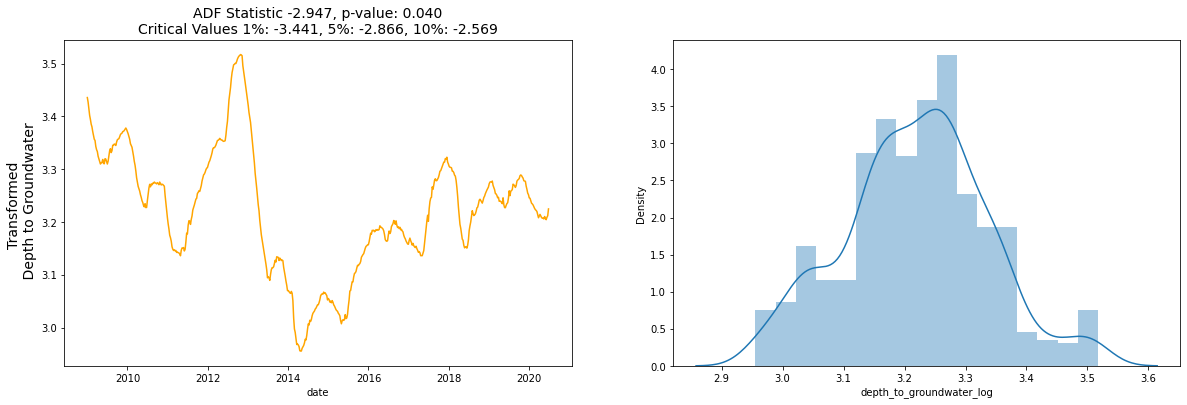

In [29]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])

### Differencing

Differencing can be done in different orders:

- First order differencing: linear trends with zi=yi−yi−1
 
- Second-order differencing: quadratic trends with zi=(yi−yi−1)−(yi−1−yi−2)
 
and so on...

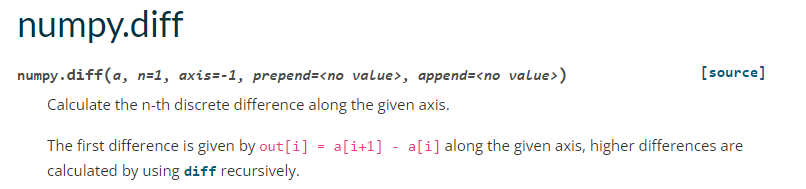

In [30]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
# we add one 0 in the first row, cause actualy it does not have one cause the 
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)
df['depth_to_groundwater_diff_1']

0      0.000000
1      0.264286
2      0.364286
3      0.401429
4      0.228571
         ...   
595    0.088571
596    0.058571
597   -0.112857
598   -0.071429
599   -0.322143
Name: depth_to_groundwater_diff_1, Length: 600, dtype: float64

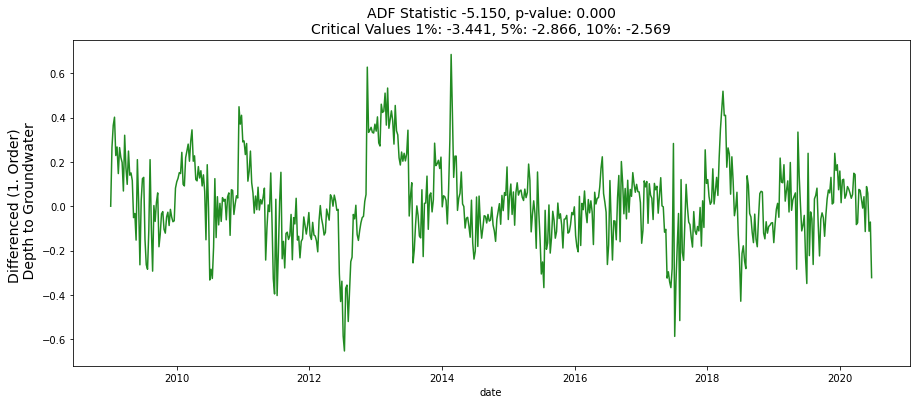

In [31]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

# Feature engineering

In [32]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']]

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1
...,...,...,...,...,...,...,...,...
595,2020-05-28,2020,5,28,149,22,2,2
596,2020-06-04,2020,6,4,156,23,2,3
597,2020-06-11,2020,6,11,163,24,2,3
598,2020-06-18,2020,6,18,170,25,2,3


## Encoding Cyclical Features

The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

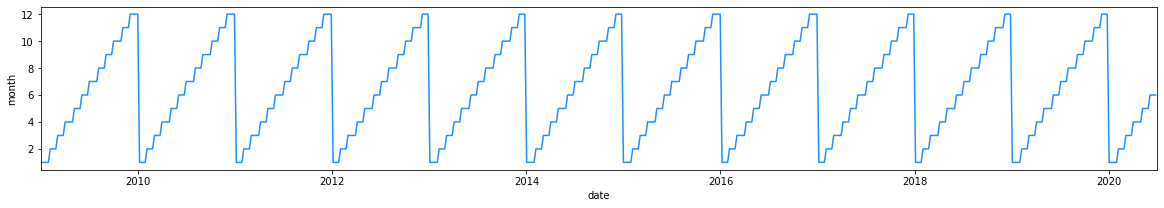

In [33]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

Lets encode this cyclical feature:

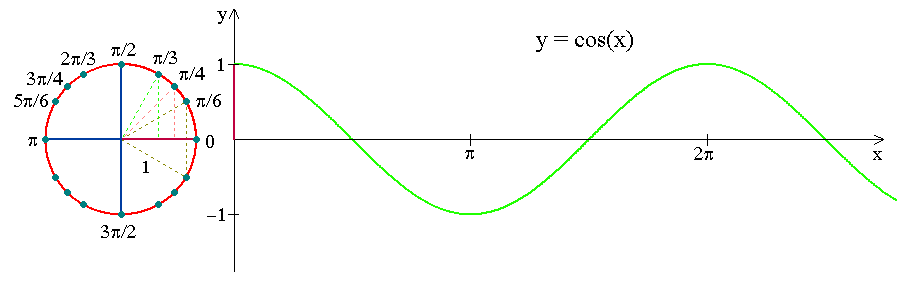

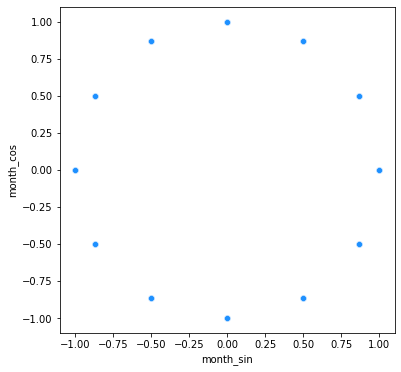

In [34]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

## TimeSeries Decomposition

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.





Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:

- Additive:  y(t)=Level+Trend+Seasonality+Noise
- Multiplicative:  y(t)=Level∗Trend∗Seasonality∗Noise
 
In this case we are going to use function seasonal_decompose() from the statsmodels library.

In [35]:
# !pip install git+https://github.com/statsmodels/statsmodels

  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-xo5venom
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-xo5venom
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.14.0.dev0+45.ge1ebcacf9-cp37-cp37m-linux_x86_64.whl size=17850455 sha256=a83fbf116d52bdb2ee1b944d650369f5f6cfd1c120953424249f7452c9010f74
  Stored in directory: /tmp/pip-ephem-wheel-cache-ptksz8_4/wheels/a7/e2/12/87eac3fb9bcec178a4228e24f5d4c0996208883c6f1b44e941
Successfully built statsmodels
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

In [41]:
for i, column in enumerate(['temperature', 'depth_to_groundwater']):
  print(i,'--',column)

0 -- temperature
1 -- depth_to_groundwater


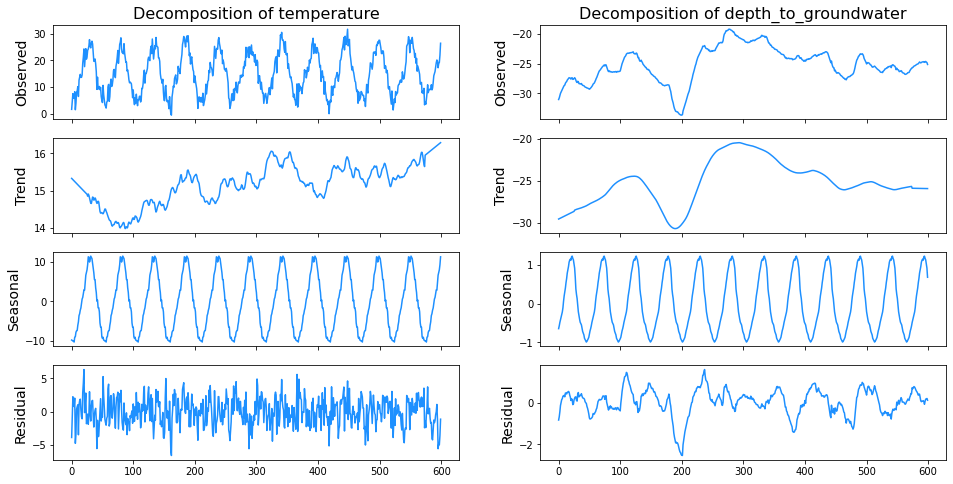

In [39]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

<iframe src="https://www.kaggle.com/embed/andreshg/timeseries-analysis-a-complete-guide/notebook?cellIds=49&kernelSessionId=55927590" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="TimeSeries Analysis 📈A Complete Guide 📚"></iframe>

## Lag

We want to calculate each variable with a shift() (lag) to compare the correlationwith the other variables.

You can see documentation of shift function for more information.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

In [42]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

# Exploratory Data Analysis

Now, we are going to plot the data and try to extract some knowledge.

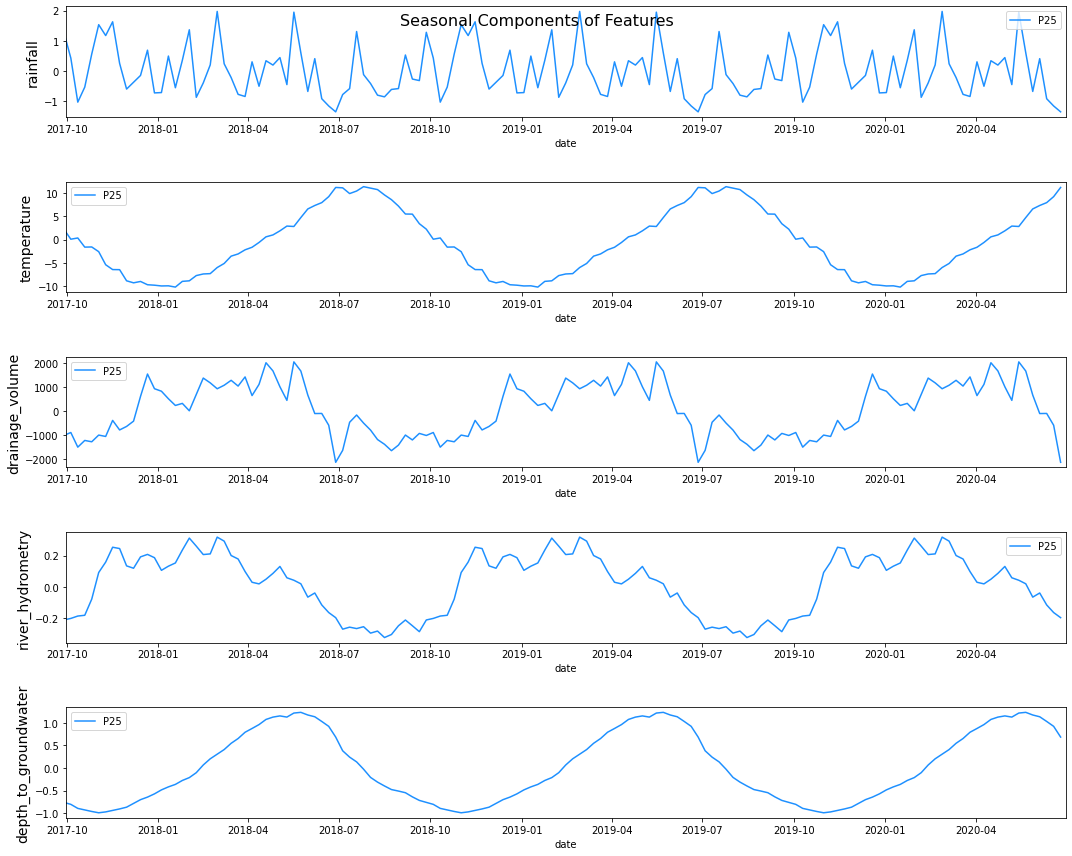

In [45]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

As we can see:

- **depth_to_groundwater**: reaches its maximum around May/June and its minimum around November
- **temperature**: reaches its maxmium around August and its minimum around January
- **drainage_volume**: reaches its minimum around July.
- **river_hydrometry**: reaches its maximum around February/March and its minimum around September

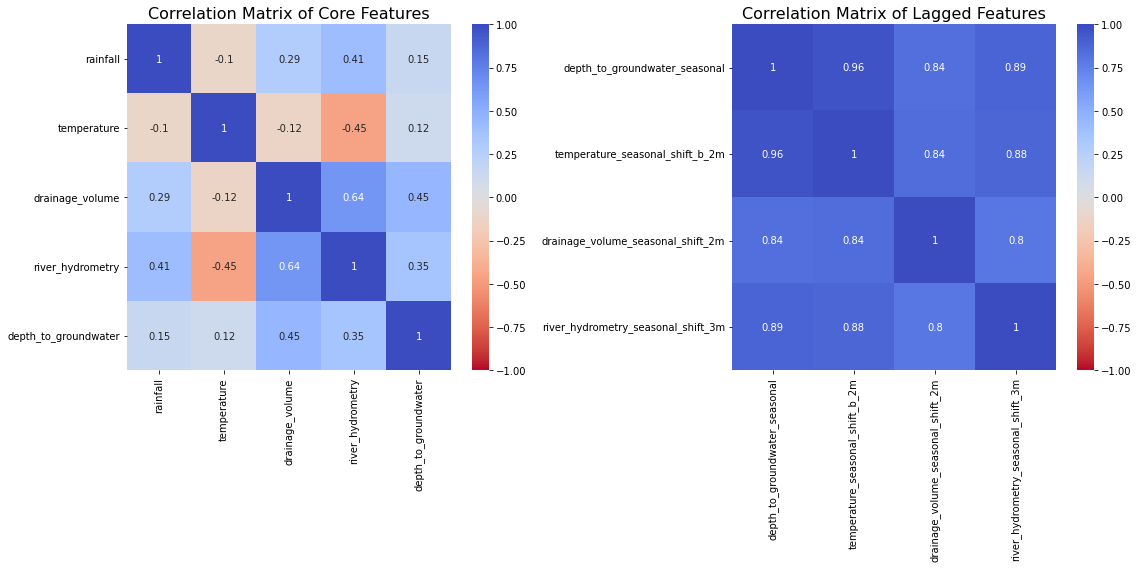

In [46]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',         
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m', 
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

As we can see, the features are higher correlated in the case of shifted features (lagged ones) than the original ones.

# Loop For Ever

In [48]:
while True: pass

KeyboardInterrupt: ignored